In [ ]:
# Install librosa for audio processing
!pip install librosa

# Install pydub and ffmpeg for audio file handling
!pip install pydub
!apt-get install ffmpeg -y

# Import libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Masking
from tensorflow.keras.callbacks import ModelCheckpoint

# Additional imports for audio processing
import soundfile as sf
from pydub import AudioSegment


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/DogBarking/'  # Change this to your dataset path


In [ ]:
# Initialize lists to hold file paths and labels
audio_files = []
labels = []

# Classes
class_labels = ['rottweller', 'labrador', 'pomeranian']  # Replace with your actual class folder names

# Map class folders to labels
class_mapping = {
    'rottweller': 'rottweller',
    'labrador': 'labrador',
    'pomeranian': 'pomeranian'
}

# Traverse through each class folder and get file paths
for class_folder in class_labels:
    label = class_mapping[class_folder]
    label_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith('.mp3'):
                file_path = os.path.join(label_path, file)
                audio_files.append(file_path)
                labels.append(label)

# Create a DataFrame
data = pd.DataFrame({'path': audio_files, 'label': labels})

print(f"Total audio files: {len(data)}")
print(data.head())


Total audio files: 49
                                                path       label
0  /content/drive/MyDrive/DogBarking/rottweller/d...  rottweller
1  /content/drive/MyDrive/DogBarking/rottweller/d...  rottweller
2  /content/drive/MyDrive/DogBarking/rottweller/g...  rottweller
3  /content/drive/MyDrive/DogBarking/rottweller/d...  rottweller
4  /content/drive/MyDrive/DogBarking/rottweller/d...  rottweller


In [ ]:
def extract_features(file_name, max_pad_len=862):
    try:
        # Load audio file using pydub
        audio = AudioSegment.from_file(file_name)
        audio = audio.set_channels(1)  # Convert to mono
        audio = audio.set_frame_rate(22050)  # Set frame rate to 22050 Hz

        # Convert to numpy array
        samples = np.array(audio.get_array_of_samples()).astype(np.float32)
        samples = samples / np.max(np.abs(samples))  # Normalize

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=samples, sr=22050, n_mfcc=40)

        # Pad or truncate the sequences to a fixed length
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        print(f"Exception: {e}")
        return None

    return mfccs


In [ ]:
# Set the maximum padding length (adjust based on your data)
max_pad_len = 862  # Adjust as needed

# Extract features and labels
features = []
for index, row in data.iterrows():
    file_name = row['path']
    class_label = row['label']
    data_point = extract_features(file_name, max_pad_len)
    if data_point is not None:
        features.append([data_point, class_label])
    else:
        print(f"Skipping file: {file_name}")

# Convert into a DataFrame
features_df = pd.DataFrame(features, columns=['feature', 'class_label'])


In [ ]:
# Convert features and labels into numpy arrays
X = np.array(features_df['feature'].tolist())
y = np.array(features_df['class_label'].tolist())

# Encode the classification labels
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape X for input into RNN
# Current shape: (num_samples, num_features, max_pad_len)
# Required shape: (num_samples, max_pad_len, num_features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[2], x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], x_test.shape[1])

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")


x_train shape: (39, 862, 40)
x_test shape: (10, 862, 40)


In [ ]:
# Get the number of classes
num_labels = y_encoded.shape[1]

# Build the RNN model
model = Sequential()

# Masking layer to handle variable sequence lengths (optional if sequences are padded)
model.add(Masking(mask_value=0., input_shape=(x_train.shape[1], x_train.shape[2])))

# First LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

# Second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_labels, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 862, 40)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 862, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 862, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,131 (531.76 KB)

 Trainable params: 136,131 (531.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up a checkpoint
# Change the filepath to end in .keras
checkpointer = ModelCheckpoint(filepath='audio_classification_rnn.keras',
                               verbose=1,
                               save_best_only=True)

# Train the model (rest of the code remains the same)
history = model.fit(x_train, y_train, batch_size=32, epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer], verbose=1)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3770 - loss: 1.0877
Epoch 1: val_loss improved from inf to 1.07372, saving model to audio_classification_rnn.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3881 - loss: 1.0828 - val_accuracy: 0.3000 - val_loss: 1.0737
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5733 - loss: 1.0015
Epoch 2: val_loss did not improve from 1.07372
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5873 - loss: 0.9974 - val_accuracy: 0.3000 - val_loss: 1.1040
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5349 - loss: 0.9362
Epoch 3: val_loss did not improve from 1.07372
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5361 - loss: 0.9384 - val_accuracy: 0.3000 - val_loss: 1.1258
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6074 - loss: 0.9302
Epoch 4: val_loss did not improve from 1.07372
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6015 - loss: 0.9327 - val_accuracy: 0.3000 - val_loss:

In [ ]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dog_audioclassificationmodel/audio_classification_rnn.keras')

# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]*100:.2f}%")


Test accuracy: 50.00%


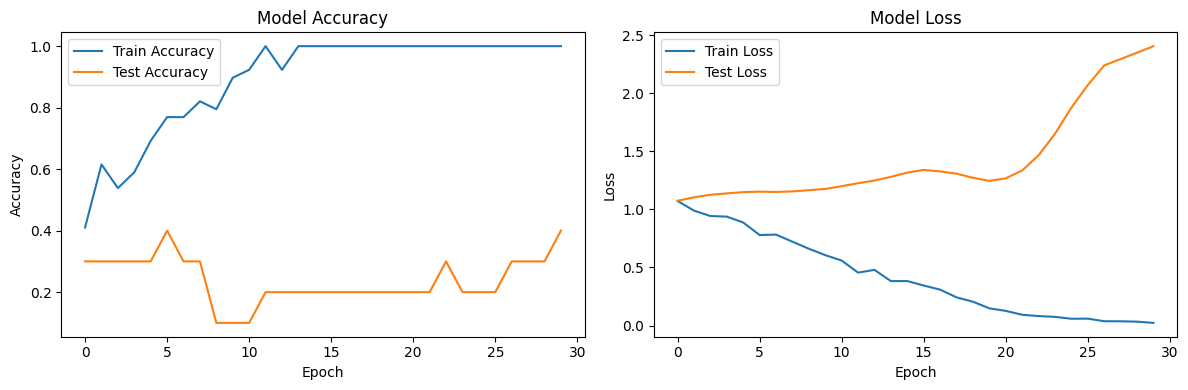

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


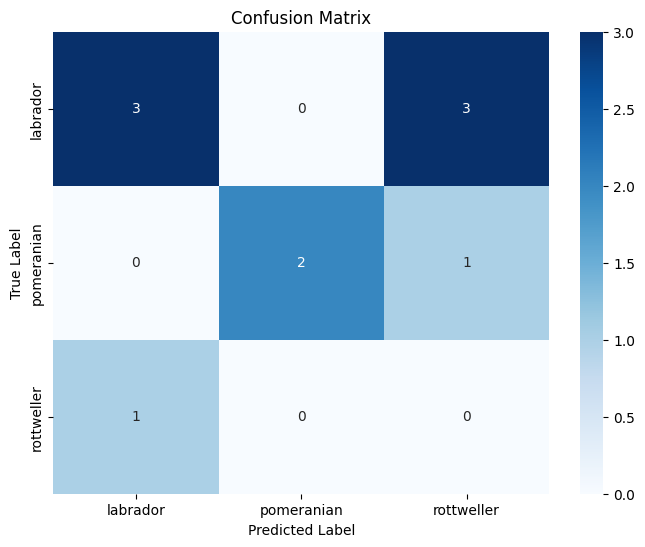

In [ ]:
# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
def predict_class(file_name):
    # Extract features
    data_point = extract_features(file_name, max_pad_len=max_pad_len)
    if data_point is not None:
        data_point = data_point.reshape(1, data_point.shape[1], data_point.shape[0])  # Reshape for input

        # Predict
        prediction = model.predict(data_point)
        predicted_label = le.inverse_transform([np.argmax(prediction)])
        return predicted_label[0]
    else:
        return "Error processing the file."

# Test with a new audio file
test_file = '/content/drive/MyDrive/DogBarking/labrador/barking-dog-close-26593.mp3'  # Change to your test file path
predicted_class = predict_class(test_file)
print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted class is: labrador
